In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm 
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from scipy.integrate import odeint
from pytensor.compile.ops import as_op
from scipy.optimize import least_squares

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.3


In [2]:
%load_ext watermark
%watermark

Last updated: 2024-01-17T14:26:35.947379-05:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.20.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
%load_ext watermark
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## Data

In [4]:
# fmt: off
data = pd.DataFrame(dict(
    year = np.arange(1900., 1921., 1),
    lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
    hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])))
data.head()
# fmt: on

year  lynx  hare
0  1900.0   4.0  30.0
1  1901.0   6.1  47.2
2  1902.0   9.8  70.2
3  1903.0  35.2  77.4
4  1904.0  59.4  36.3

In [5]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="Hudson's Bay Company Data"):
    ax.plot(data.year, data.lynx, color="b", lw=lw, marker="o", markersize=12, label="Lynx (Data)")
    ax.plot(data.year, data.hare, color="g", lw=lw, marker="+", markersize=14, label="Hare (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([1900, 1920])
    ax.set_ylim(0)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Pelts (Thousands)", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)
    return ax

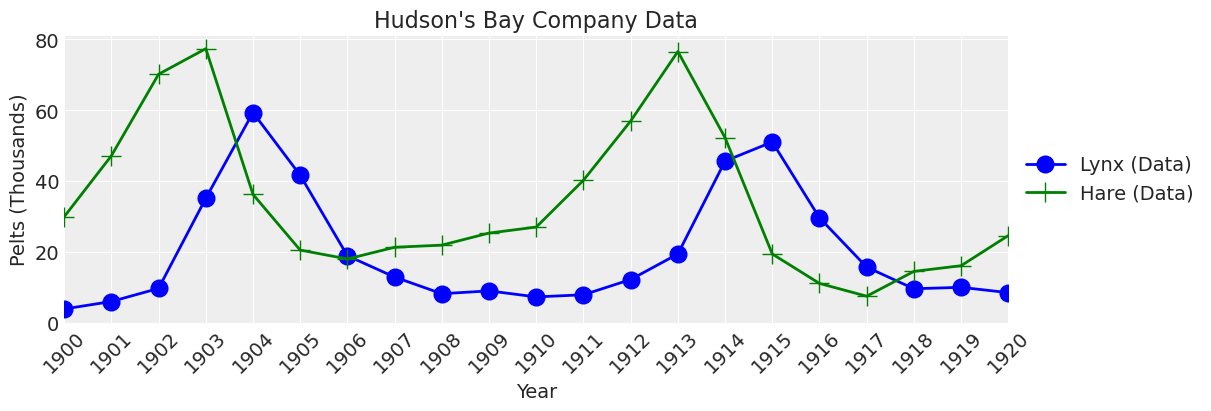

In [6]:
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax);

In [7]:
@njit
def rhs(X, t, theta):
    # unpack parameters
    x, y = X
    alpha, beta, gamma, delta, xt0, yt0 = theta
    # equations
    dx_dt = alpha * x - beta * x * y
    dy_dt = -gamma * y + delta * x * y
    return [dx_dt, dy_dt]

In [8]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=np.arange(1900, 1921, 0.01),
    alpha=1,
    lw=3,
    title="Hudson's Bay Company Data and\nExample Model Run",
):
    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Lynx (Model)")
    ax.plot(time, x_y[:, 0], color="g", alpha=alpha, lw=lw, label="Hare (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

In [9]:
theta = np.array([0.52, 0.026, 0.84, 0.026, 34.0, 5.9])
time = np.arange(1900, 1921, 0.01)
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))

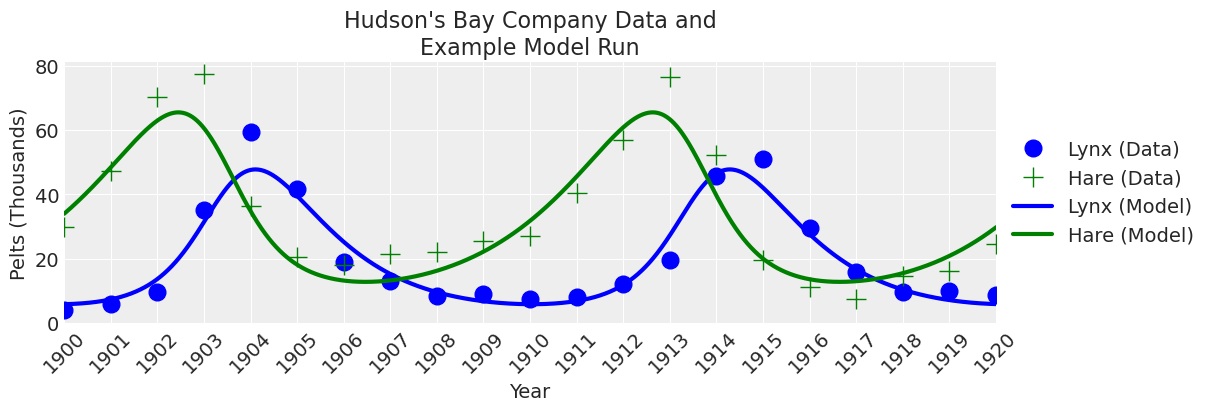

In [10]:
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y);

# Least Squares Solution

In [11]:
# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    return(
        data[["hare", "lynx"]] - odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))  
    ).values.flatten()

In [12]:
# calculate least squares using the scipy solver
results = least_squares(ode_model_resid, x0=theta)
# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = ["alpha", "beta", "gamma", "delta", "h0", "l0"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results.x
df.round(2)

Parameter  Least Squares Solution
0     alpha                    0.48
1      beta                    0.02
2     gamma                    0.93
3     delta                    0.03
4        h0                   34.91
5        l0                    3.86

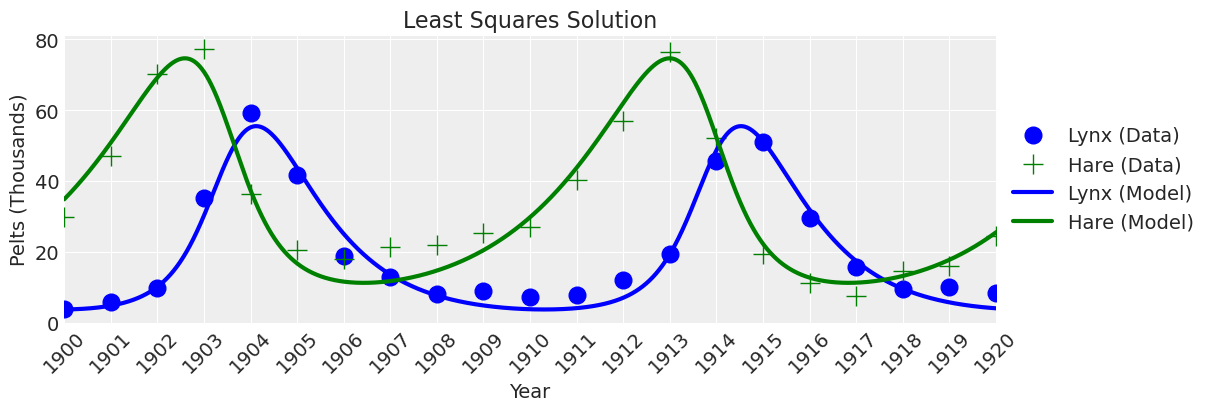

In [13]:
time = np.arange(1900, 1921, 0.01)
theta = results.x
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y, title="Least Squares Solution");

## PyMC Model

In [14]:
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))

In [15]:
theta = results.x # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)
    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([alpha, beta, gamma, delta, xt0, yt0])
    )
    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx"]].values)

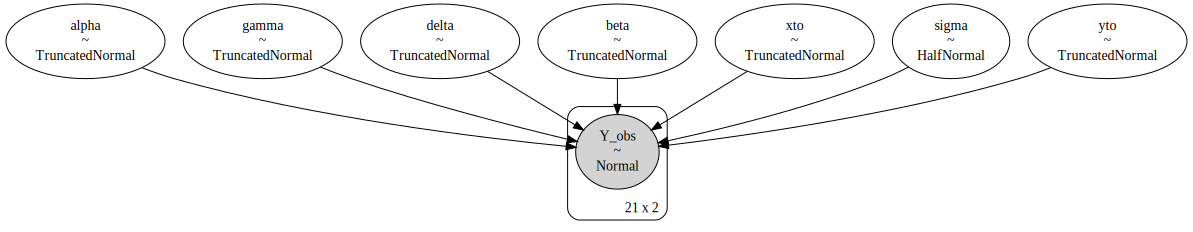

In [16]:
pm.model_to_graphviz(model=model)

## Plotting Functions

In [17]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["alpha", "beta", "gamma", "delta", "xto", "yto"]
    row = trace_df.iloc[row_idx, :][cols].values
    time = np.arange(1900, 1921, 0.01)
    theta = row
    x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha)

In [30]:
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hudson's Bay Company Data and \nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

## Gradient-Free Sampler Options
- Slice: the default gradient-free sampler
- DEMetropolisz: a differential evolution Metropolis sampler that uses the past to inform sampling jumps
- DEMetropolis: a differential evolution Metropolis sampler
- Metropolis: the vanilla Metropolis sampler
- SMC - Sequential Monte Carlo

## Slice Sampler

In [20]:
vars_list = list(model.values_to_rvs.keys())[:-1]

In [36]:
sampler = "Slice Sampler"
tune = draws = 2000
with model:
    trace_slice = pm.sample(step=[pm.Slice(vars_list)], tune=tune, draws=draws, cores=2)

trace = trace_slice
az.summary(trace)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [gamma]
>Slice: [delta]
>Slice: [xto]
>Slice: [yto]
>Slice: [sigma]


ParallelSamplingError: Chain 0 failed with: The model could not be unpickled. This is required for sampling with more than one core and multiprocessing context spawn or forkserver.

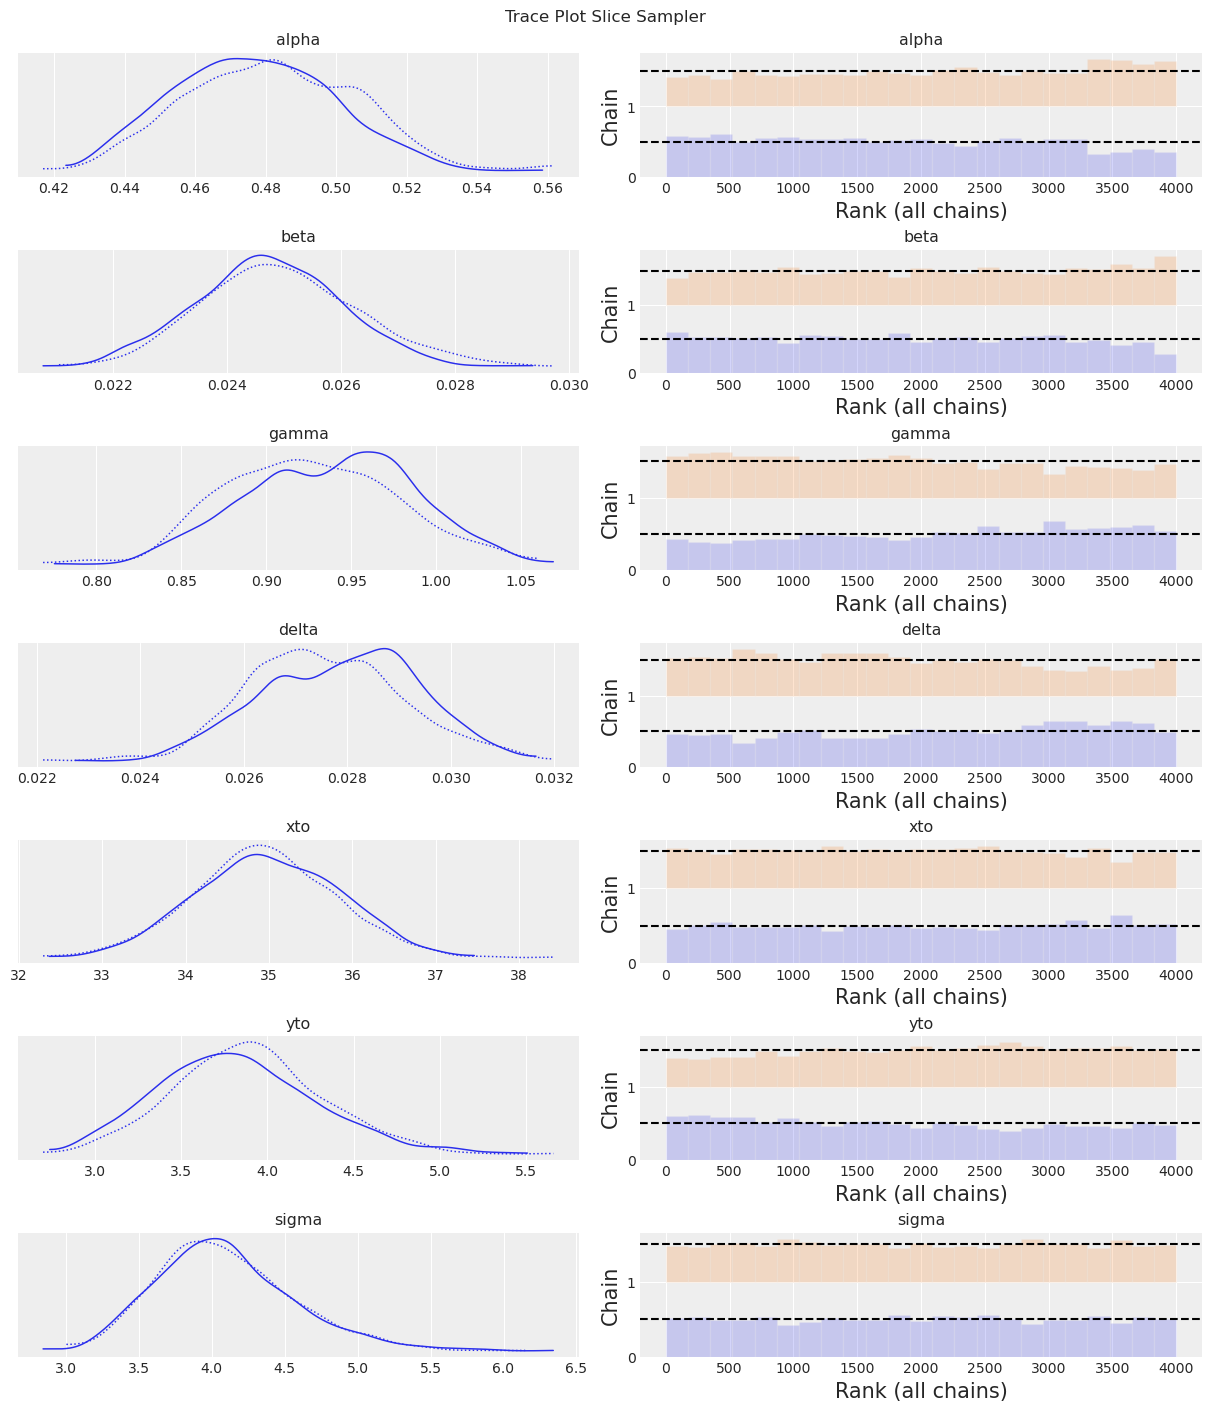

In [26]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

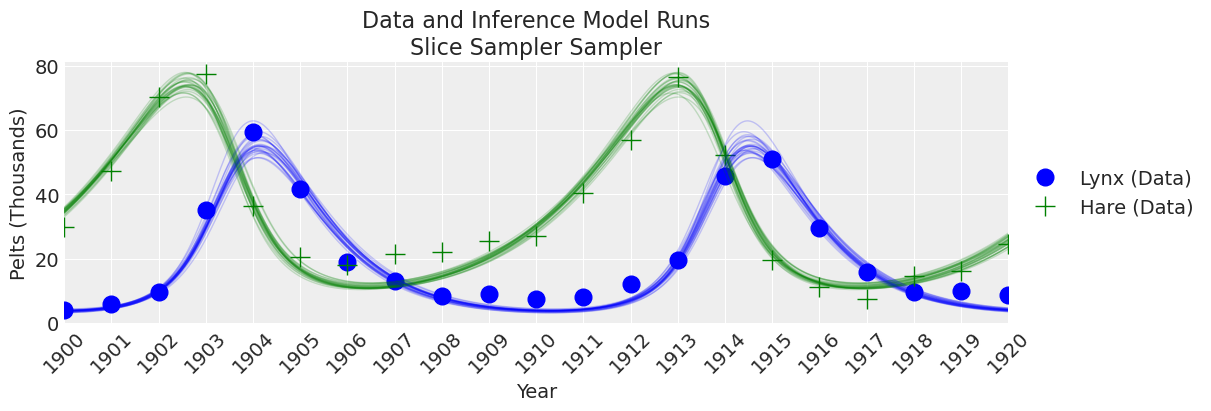

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

## DE MetropolisZ Sampler


In [34]:
sampler = "DeMetropolisZ"
tune = draws = 5000
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, cores=1)

trace = trace_DEMZ
az.summary(trace)

Sequential sampling (2 chains in 1 job)
DEMetropolisZ: [alpha, beta, gamma, delta, xto, yto, sigma]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 45 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.482  0.024   0.437    0.526      0.001    0.001     416.0     598.0   
beta    0.025  0.001   0.022    0.027      0.000    0.000     470.0     647.0   
gamma   0.925  0.051   0.839    1.031      0.002    0.002     434.0     548.0   
delta   0.028  0.002   0.025    0.031      0.000    0.000     431.0     705.0   
xto    34.923  0.818  33.414   36.456      0.043    0.030     368.0     621.0   
yto     3.927  0.461   3.083    4.814      0.023    0.016     401.0     590.0   
sigma   4.095  0.471   3.239    4.954      0.023    0.016     429.0     627.0   

       r_hat  
alpha   1.00  
beta    1.00  
gamma   1.00  
delta   1.00  
xto     1.01  
yto     1.00  
sigma   1.00

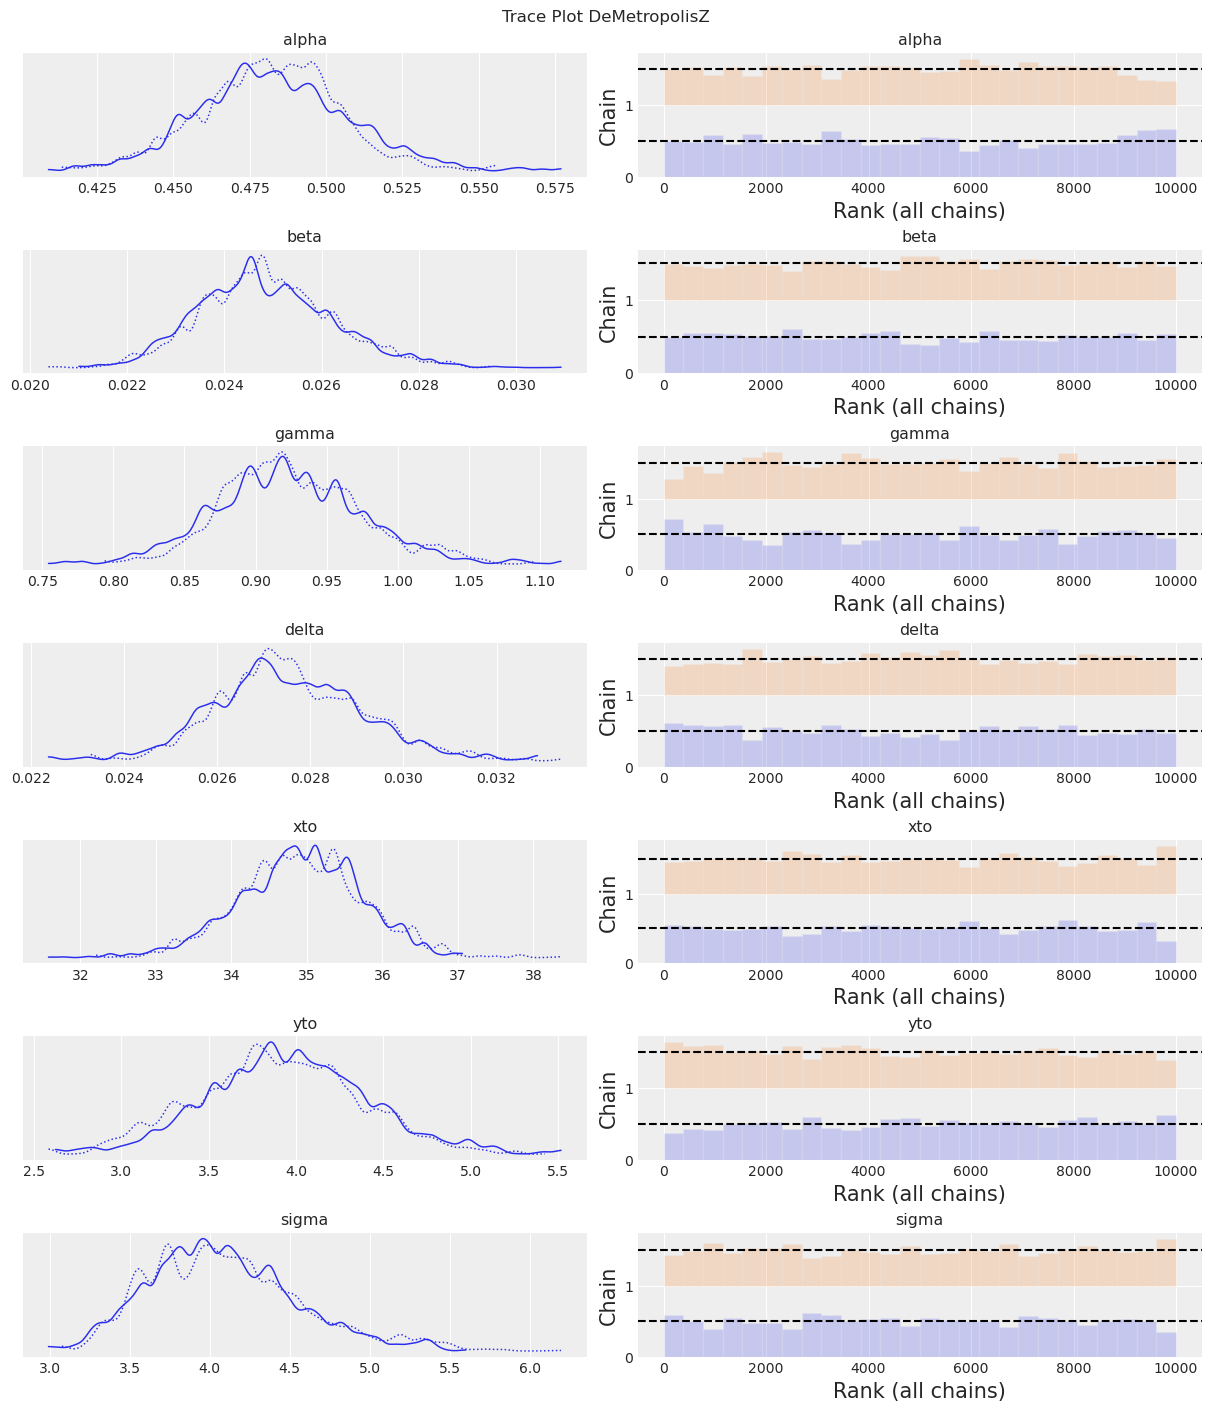

In [35]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

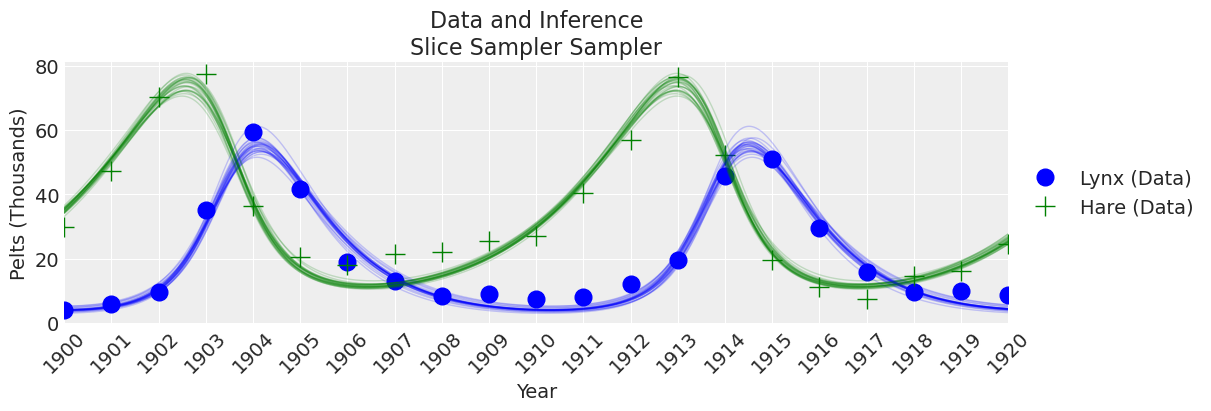

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference\n{sampler} Sampler")


## DEMetropolis Sampler

In [40]:
sampler = "DEMetropolis"
chains = 8
draws = 6000
with model:
    trace_DEM = pm.sample(step=[pm.DEMetropolis(vars_list)], draws=draws, chains=chains, cores=1)
trace = trace_DEM
az.summary(trace)

Population sampling (8 chains)
DEMetropolis: [alpha, beta, gamma, delta, xto, yto, sigma]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.


Sampling 8 chains for 1_000 tune and 6_000 draw iterations (8_000 + 48_000 draws total) took 122 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.482  0.021   0.443    0.522      0.000    0.000    1922.0    3631.0   
beta    0.025  0.001   0.023    0.027      0.000    0.000    1848.0    3085.0   
gamma   0.926  0.044   0.843    1.009      0.001    0.001    1834.0    3416.0   
delta   0.028  0.001   0.025    0.030      0.000    0.000    1802.0    3212.0   
xto    34.924  0.769  33.472   36.390      0.017    0.012    1937.0    3404.0   
yto     3.883  0.400   3.137    4.626      0.010    0.007    1700.0    3221.0   
sigma   4.046  0.414   3.300    4.816      0.011    0.008    1471.0    2801.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
delta    1.0  
xto      1.0  
yto      1.0  
sigma    1.0

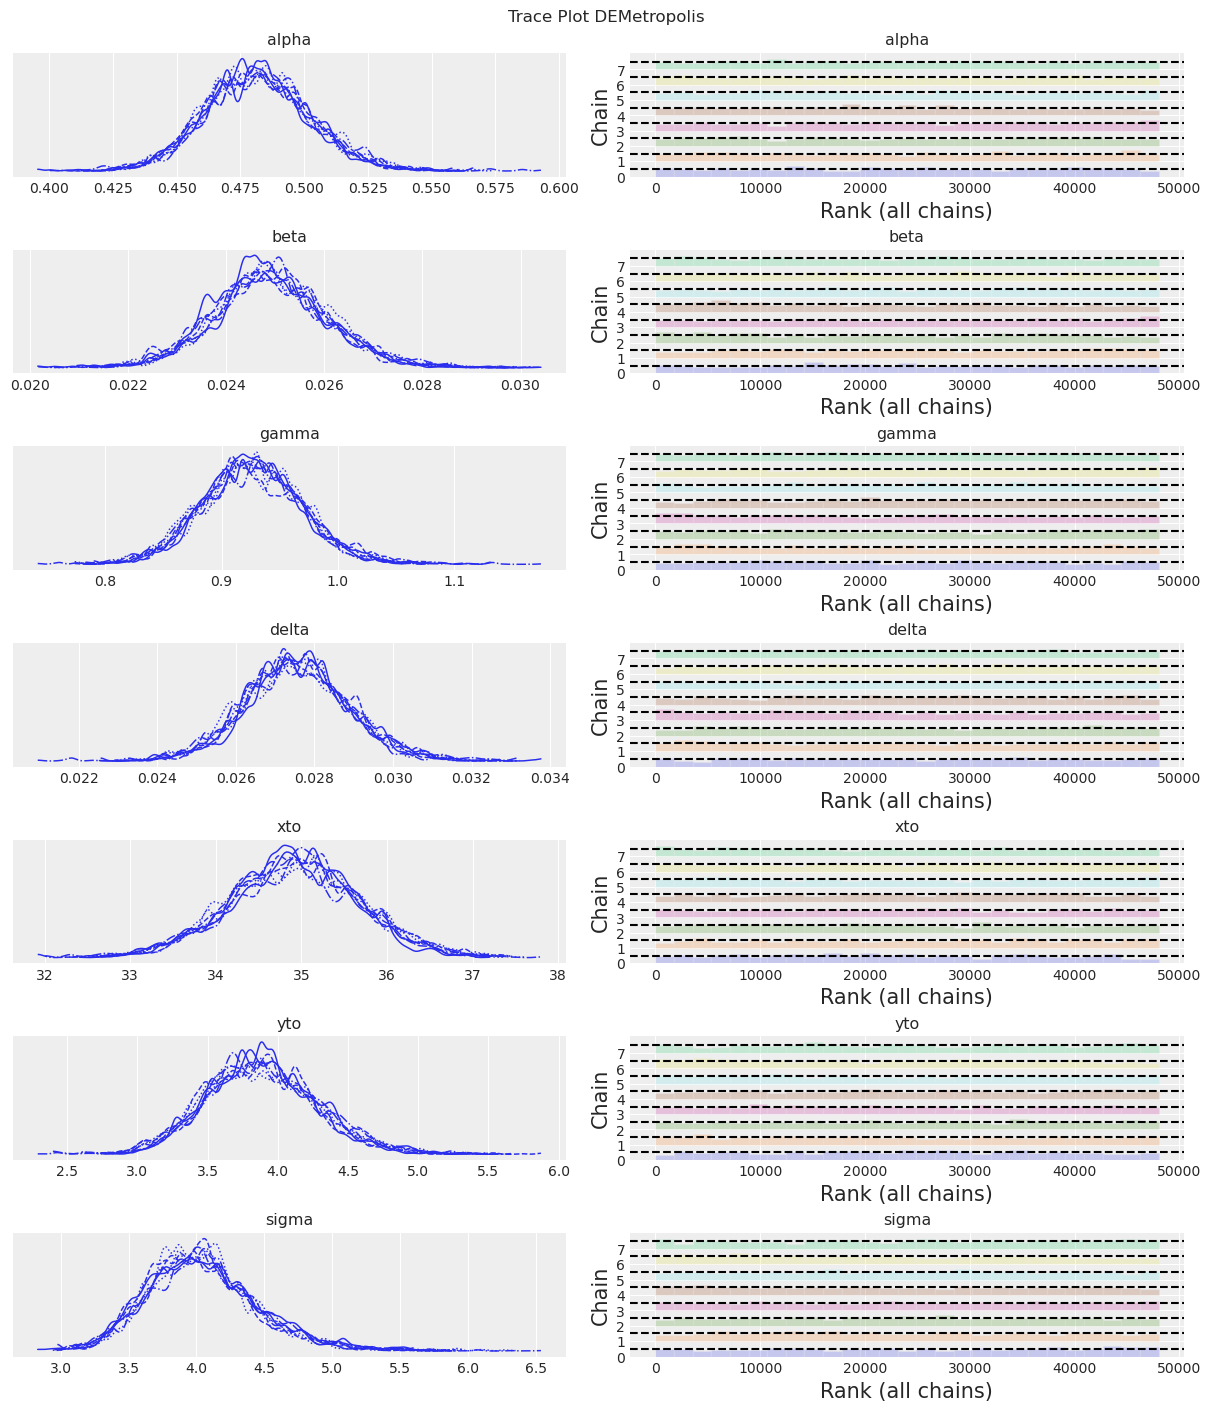

In [42]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

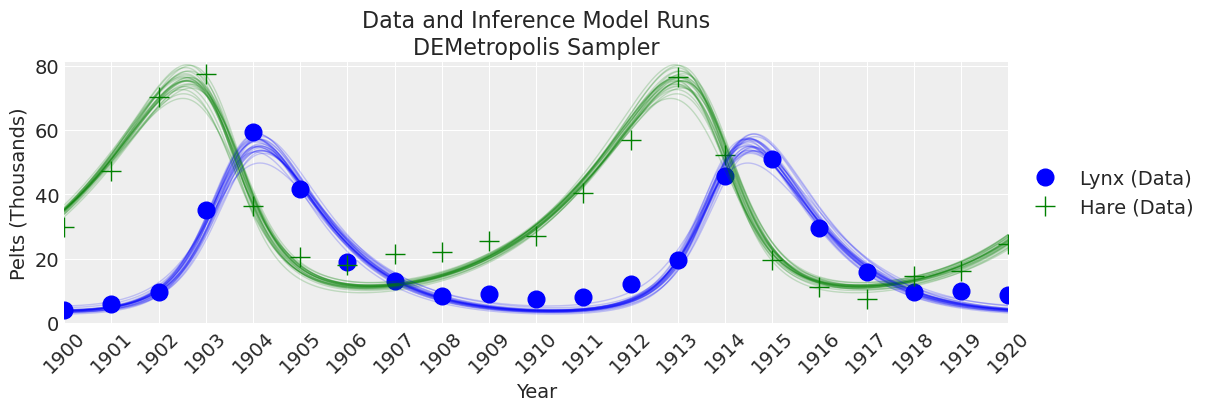

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

## Metropolis Sampler

In [45]:
sampler = "Metropolis"
tune = draws = 5000
with model:
    trace_M = pm.sample(step=[pm.Metropolis(vars_list)], tune=tune, draws=draws, chains=4, cores=1)
trace = trace_M
az.summary(trace)

Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [gamma]
>Metropolis: [delta]
>Metropolis: [xto]
>Metropolis: [yto]
>Metropolis: [sigma]


D:\Users\Roberth\Desktop\B_P\entornop\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 945 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.477  0.021   0.443    0.519      0.008    0.006       7.0      26.0   
beta    0.025  0.001   0.023    0.027      0.000    0.000      29.0     156.0   
gamma   0.939  0.048   0.860    1.025      0.019    0.014       7.0      17.0   
delta   0.028  0.002   0.026    0.031      0.001    0.000       7.0      15.0   
xto    34.848  0.814  33.313   36.453      0.094    0.067      75.0     180.0   
yto     3.784  0.459   2.956    4.602      0.135    0.098      12.0      59.0   
sigma   4.115  0.491   3.259    5.061      0.013    0.010    1336.0    1770.0   

       r_hat  
alpha   1.60  
beta    1.13  
gamma   1.66  
delta   1.67  
xto     1.04  
yto     1.28  
sigma   1.01

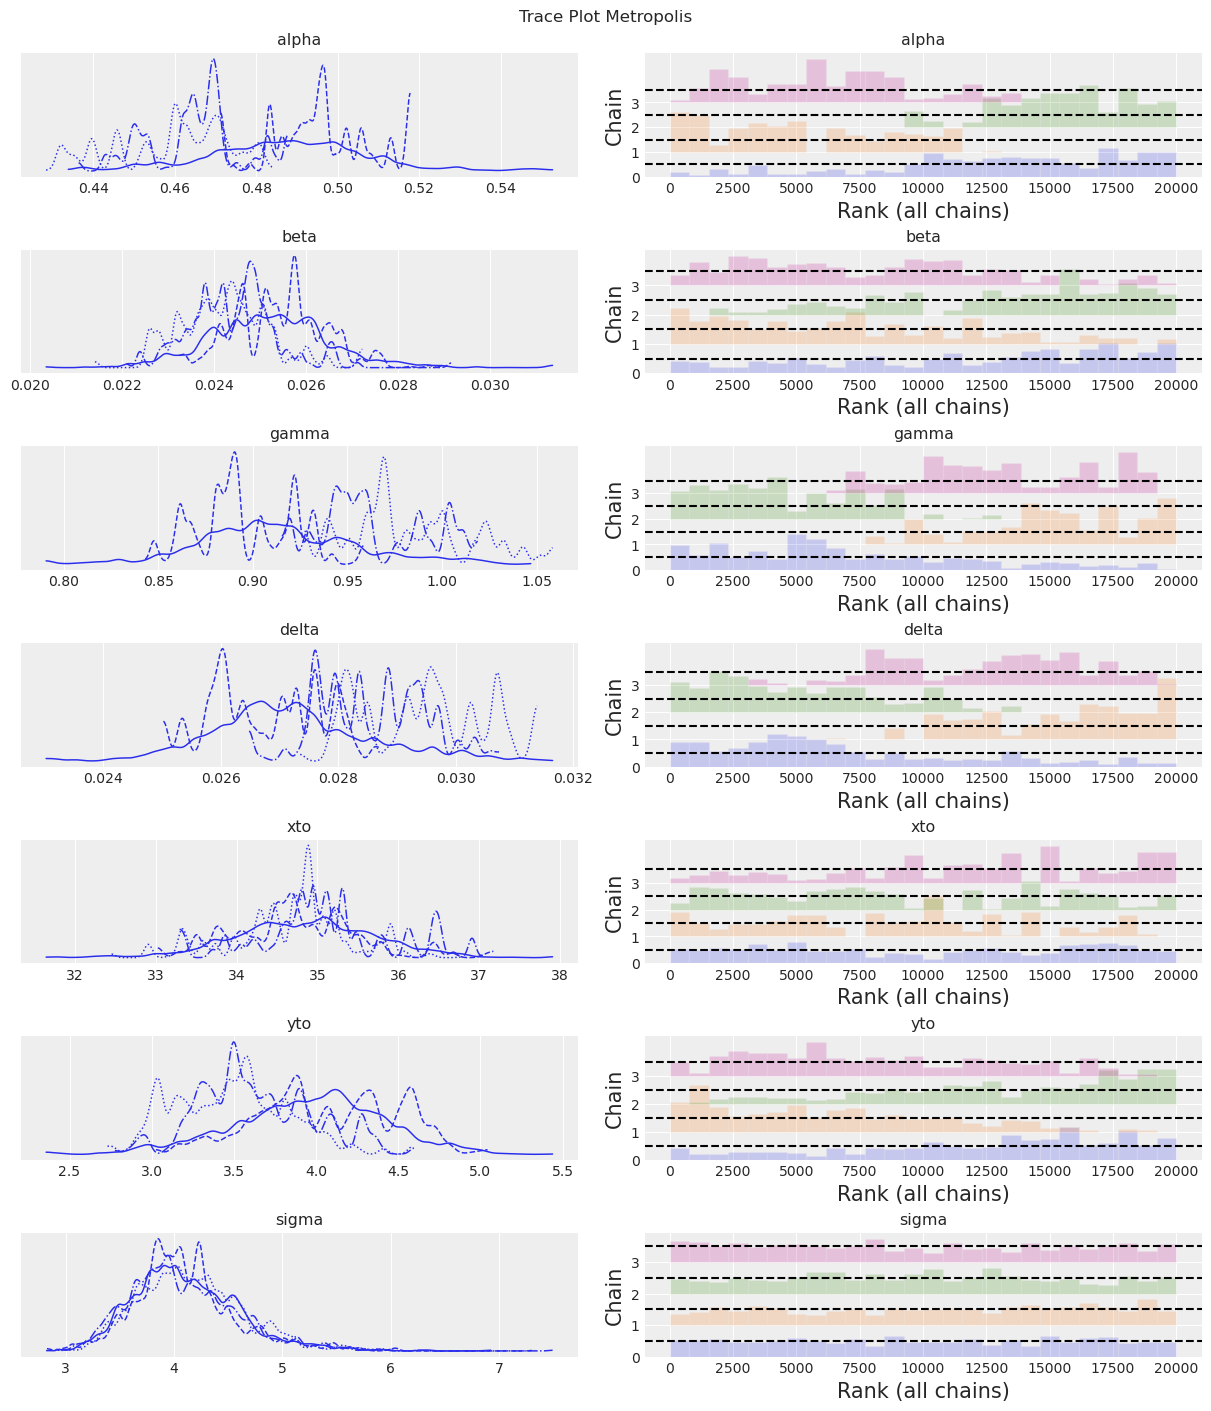

In [46]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");


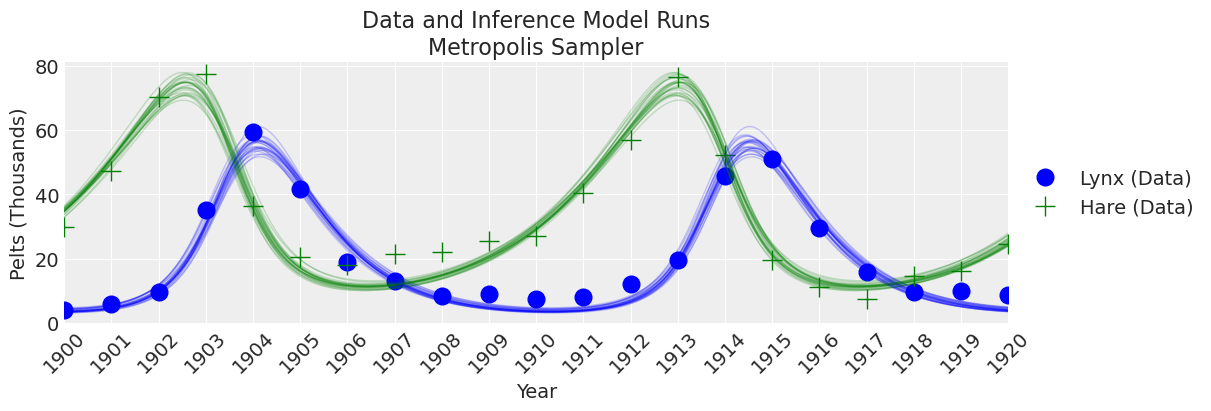

In [47]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");


## SMC Sampler


In [49]:
sampler = "SMC with Likelihood"
draws = 2000
with model:
    trace_SMC_like = pm.sample_smc(draws, cores=1)
trace = trace_SMC_like
az.summary(trace)

Initializing SMC sampler...
Sampling 2 chains in 1 job


We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.483  0.025   0.433    0.529      0.000    0.000    3953.0    3729.0   
beta    0.025  0.001   0.023    0.028      0.000    0.000    4127.0    3923.0   
gamma   0.926  0.054   0.829    1.033      0.001    0.001    3907.0    3837.0   
delta   0.028  0.002   0.025    0.031      0.000    0.000    3930.0    3723.0   
xto    34.887  0.838  33.299   36.413      0.013    0.009    4098.0    4135.0   
yto     3.899  0.481   3.026    4.825      0.008    0.005    3883.0    3766.0   
sigma   4.111  0.484   3.292    5.057      0.008    0.006    3799.0    3654.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
delta    1.0  
xto      1.0  
yto      1.0  
sigma    1.0

In [50]:
trace.sample_stats._t_sampling

229.5593044757843

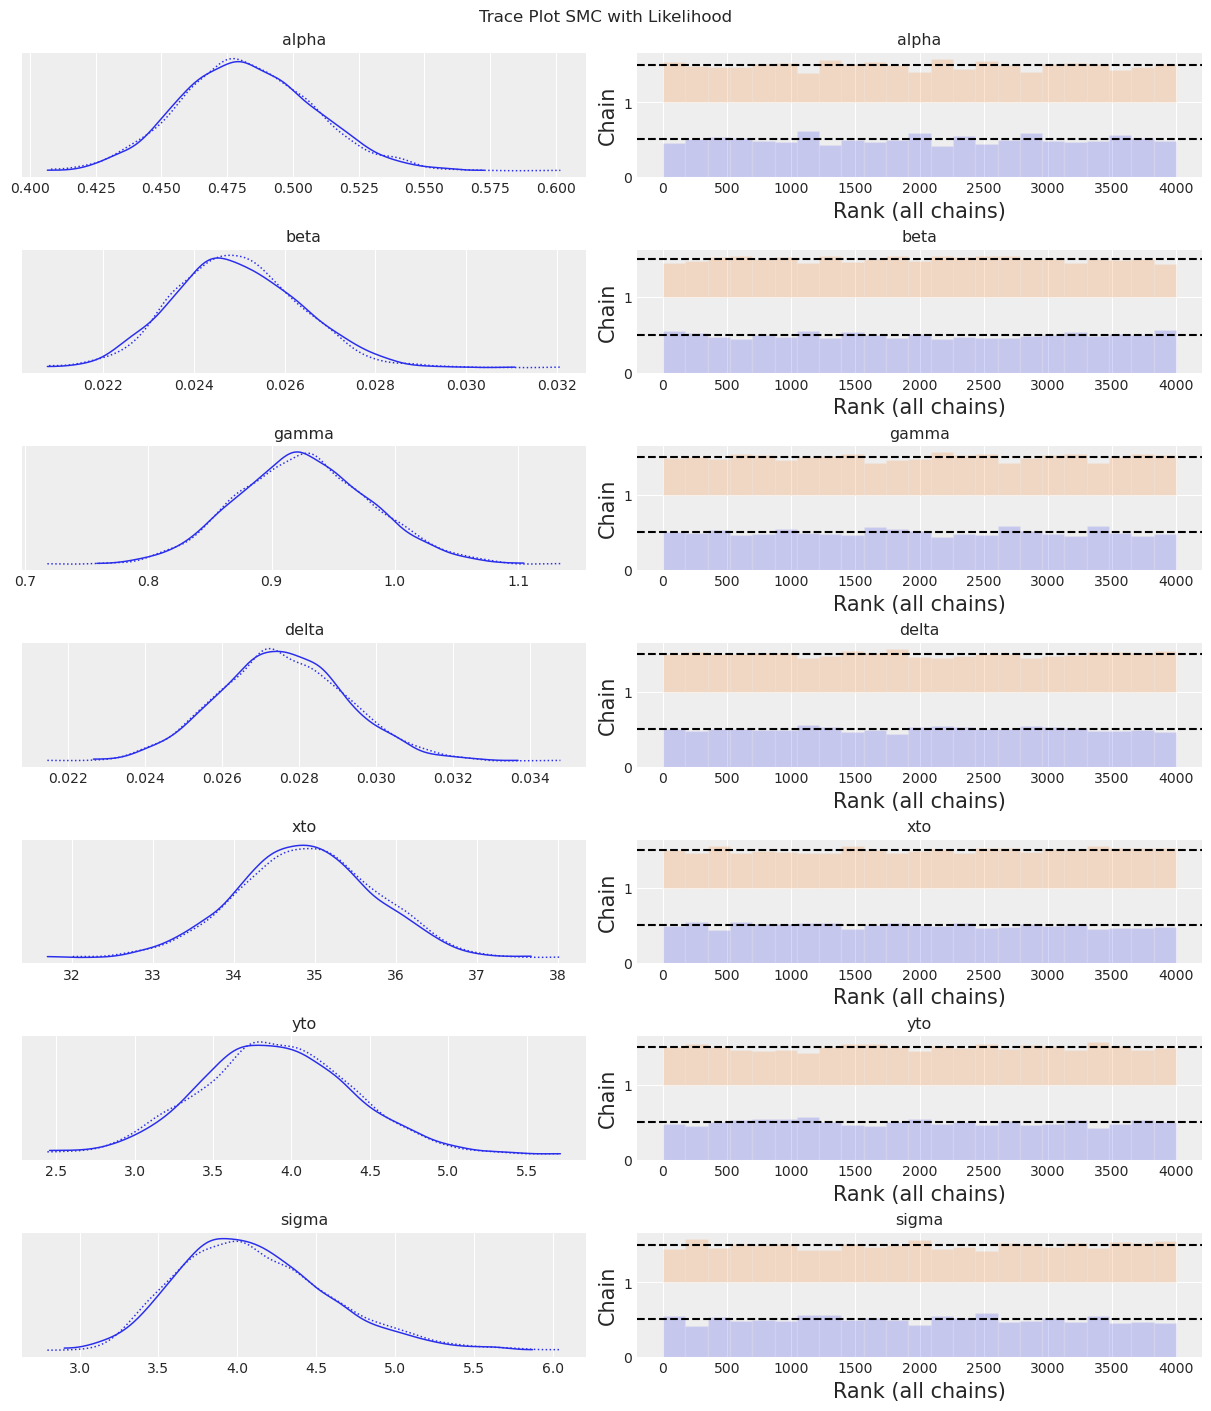

In [51]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

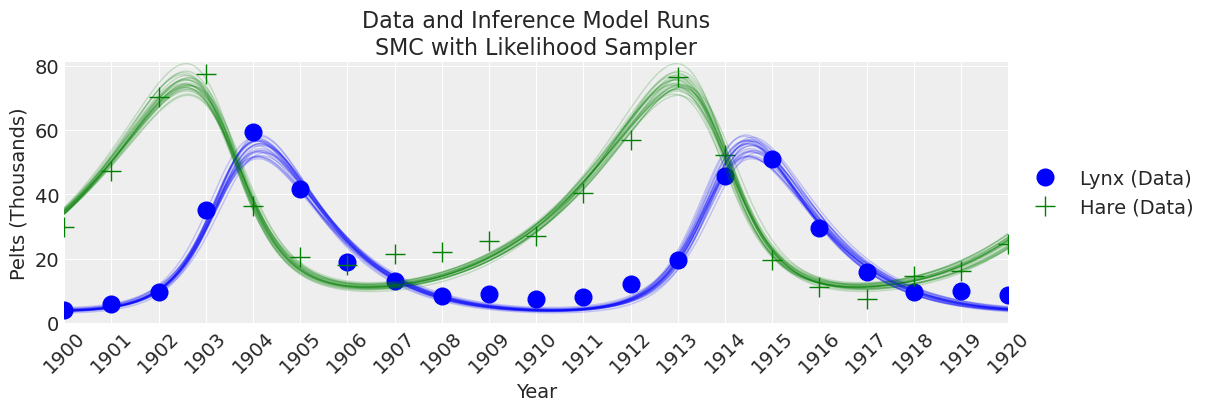

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

## SMC Using pm.Simulator Epsilon=1

In [53]:
# simulator function based on the signature rng, parameters, size.
def simulator_forward_model(rng, alpha, beta, gamma, delta, xt0, yt0, sigma, size=None):
    theta = alpha, beta, gamma, delta, xt0, yt0
    mu = odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))
    return rng.normal(mu, sigma)

In [54]:
with pm.Model() as model:
    # Specify prior distributions for model parameters
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # ode_solution
    pm.Simulator(
        "Y_obs",
        simulator_forward_model,
        params=(alpha, beta, gamma, delta, xt0, yt0, sigma),
        epsilon=1,
        observed=data[["hare", "lynx"]].values,
    )

In [55]:
sampler = "SMC_epsilon=1"
draws = 2000
with model:
    trace_SMC_e1 = pm.sample_smc(draws=draws, progressbar=False)
trace = trace_SMC_e1
az.summary(trace)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.484  0.006   0.475    0.490      0.003    0.002       5.0       4.0   
beta    0.025  0.001   0.024    0.026      0.000    0.000       5.0      11.0   
gamma   0.920  0.007   0.914    0.928      0.003    0.002       5.0      11.0   
delta   0.027  0.000   0.027    0.027      0.000    0.000       7.0       5.0   
xto    34.910  0.534  34.207   35.688      0.265    0.203       4.0       4.0   
yto     3.978  0.300   3.623    4.327      0.132    0.099       5.0       4.0   
sigma   1.426  0.176   1.234    1.736      0.075    0.056       5.0       4.0   

       r_hat  
alpha   4.94  
beta    2.22  
gamma   2.18  
delta   1.65  
xto     5.97  
yto     2.17  
sigma   2.47

D:\Users\Roberth\Desktop\B_P\entornop\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
D:\Users\Roberth\Desktop\B_P\entornop\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
D:\Users\Roberth\Desktop\B_P\entornop\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
D:\Users\Roberth\Desktop\B_P\entornop\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
D:\Users\Roberth\Desktop

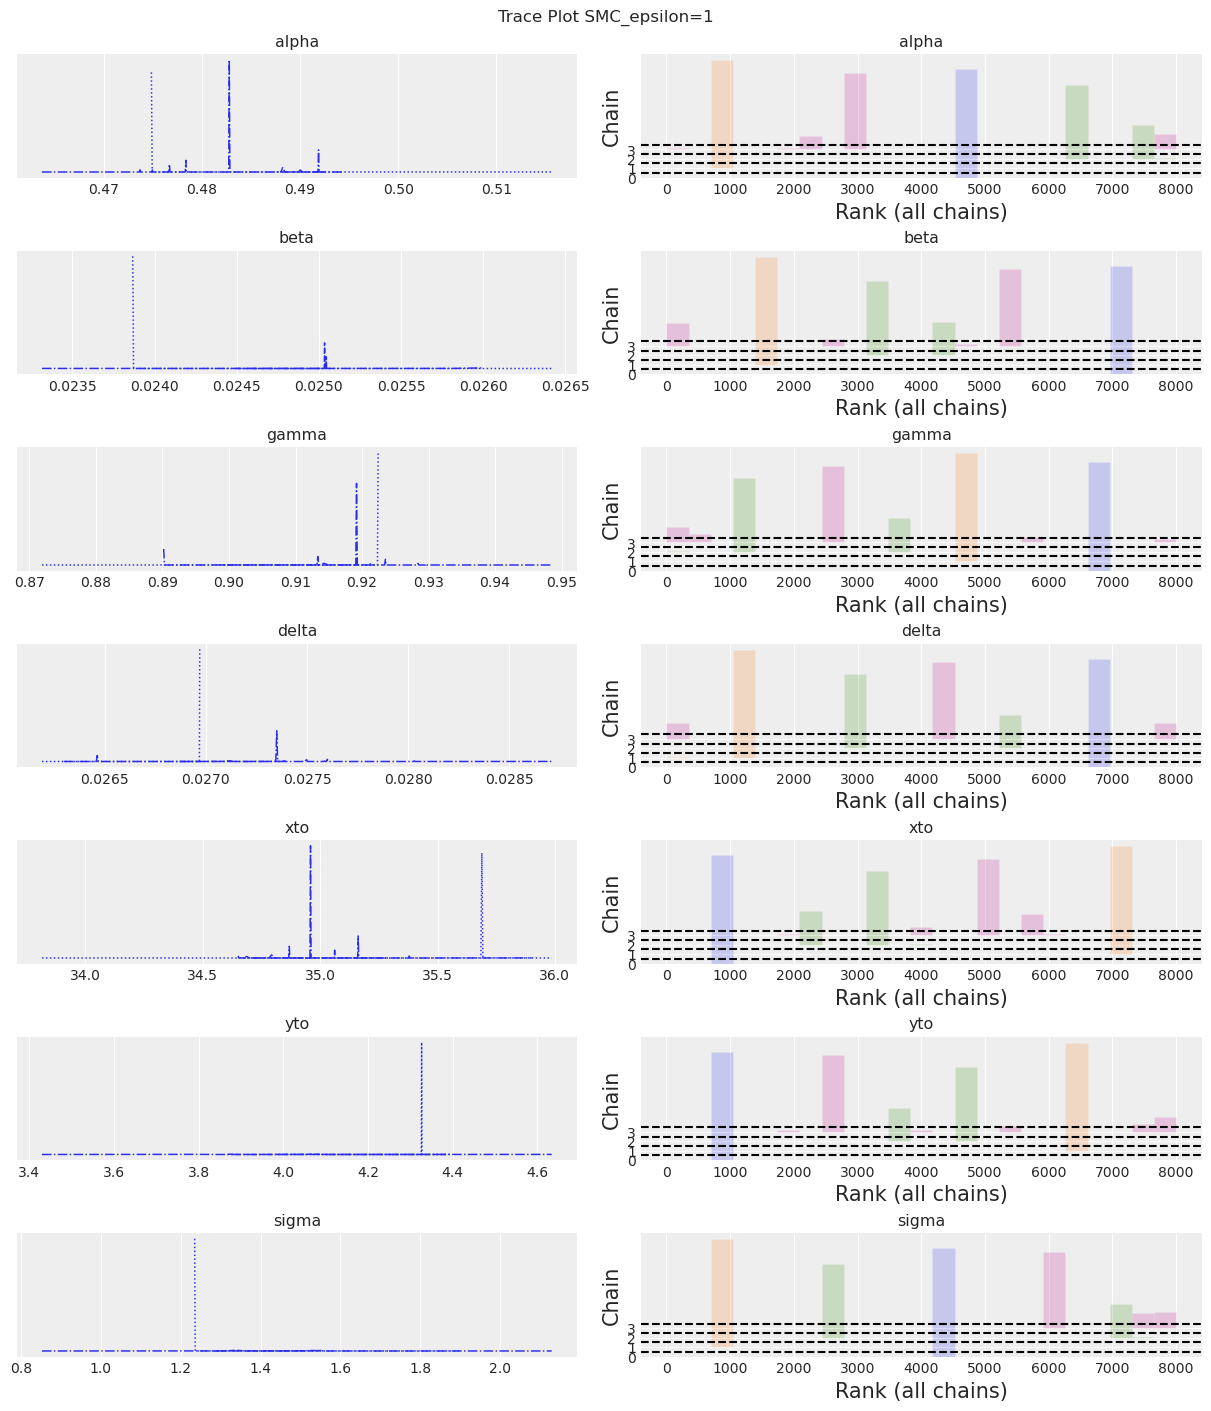

In [56]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

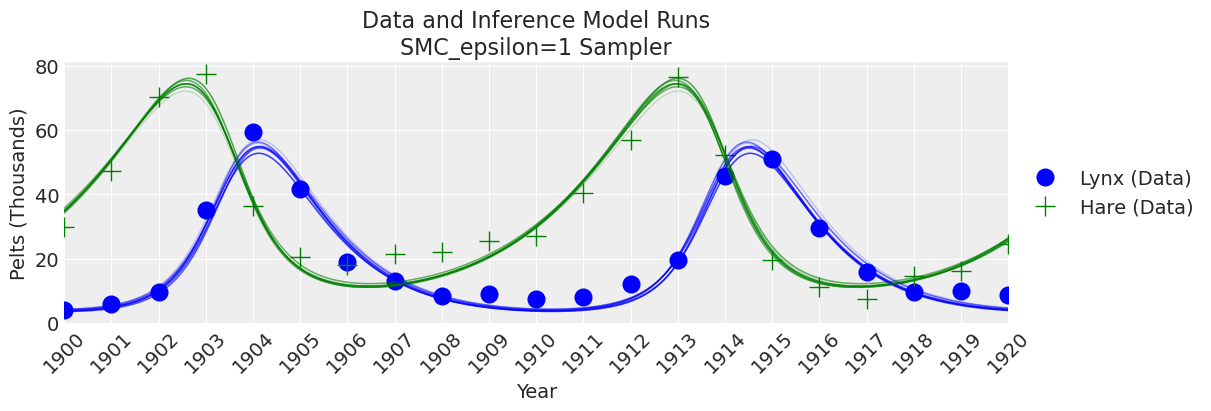

In [57]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

## SMC with Epsilon=10

In [58]:
with pm.Model() as model:
    # Specify prior distributions for model parameters
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # ode_solution
    pm.Simulator(
        "Y_obs",
        simulator_forward_model,
        params=(alpha, beta, gamma, delta, xt0, yt0, sigma),
        epsilon=10,
        observed=data[["hare", "lynx"]].values,
    )

In [60]:
sampler = "SMC epsilon=10"
draws = 2000
with model:
    trace_SMC_e10 = pm.sample_smc(draws=draws, progressbar=False)
trace = trace_SMC_e10
az.summary(trace)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.483  0.035   0.414    0.547      0.000    0.000    7502.0    6815.0   
beta    0.025  0.003   0.021    0.031      0.000    0.000    7727.0    7713.0   
gamma   0.928  0.072   0.794    1.064      0.001    0.001    7681.0    7521.0   
delta   0.028  0.002   0.023    0.032      0.000    0.000    7337.0    7090.0   
xto    34.884  0.948  33.090   36.624      0.011    0.008    7626.0    7292.0   
yto     3.903  0.715   2.595    5.294      0.008    0.006    8024.0    8088.0   
sigma   1.429  1.088   0.013    3.373      0.013    0.009    7040.0    7106.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
delta    1.0  
xto      1.0  
yto      1.0  
sigma    1.0

D:\Users\Roberth\Desktop\B_P\entornop\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


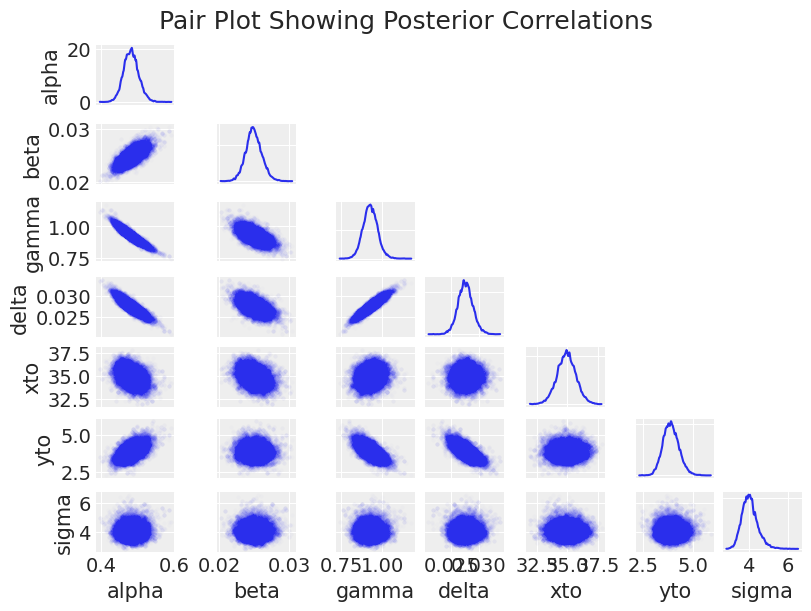

In [61]:
az.plot_pair(trace_DEM, figsize=(8, 6), scatter_kwargs=dict(alpha=0.01), marginals=True)
plt.suptitle("Pair Plot Showing Posterior Correlations", size=18);

## Bayesian Inference with Gradients

## PyMC ODE Module

In [62]:
def rhs_pymcode(y, t, p):
    dX_dt = p[0] * y[0] - p[1] * y[0] * y[1]
    dY_dt = -p[2] * y[1] + p[3] * y[0] * y[1]
    return [dX_dt, dY_dt]

In [63]:
ode_model = DifferentialEquation(
    func=rhs_pymcode, times=data.year.values, n_states=2, n_theta=4, t0=data.year.values[0]
)

## Inference with NUTS

In [64]:
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # ode_solution
    ode_solution = ode_model(y0=[xt0, yt0], theta=[alpha, beta, gamma, delta])

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx"]].values)

In [65]:
sampler = "NUTS PyMC ODE"
tune = draws = 15
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws)

Only 15 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, xto, yto, sigma]


Sampling 4 chains for 15 tune and 15 draw iterations (60 + 60 draws total) took 157 seconds.
The number of samples is too small to check convergence reliably.


In [66]:
trace = trace_pymc_ode
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.442  0.109   0.149    0.544      0.040    0.029       9.0      19.0   
beta    0.024  0.002   0.020    0.028      0.001    0.000      16.0      20.0   
gamma   0.942  0.102   0.792    1.105      0.027    0.020      12.0      43.0   
delta   0.028  0.003   0.024    0.036      0.001    0.001      11.0      23.0   
xto    34.868  0.957  33.256   36.476      0.135    0.096      47.0      64.0   
yto     4.069  0.671   3.025    5.130      0.223    0.163      10.0      35.0   
sigma   8.211  5.835   3.798   20.873      2.139    1.576       8.0      18.0   

       r_hat  
alpha   2.23  
beta    1.27  
gamma   1.52  
delta   1.55  
xto     1.04  
yto     1.85  
sigma   2.75

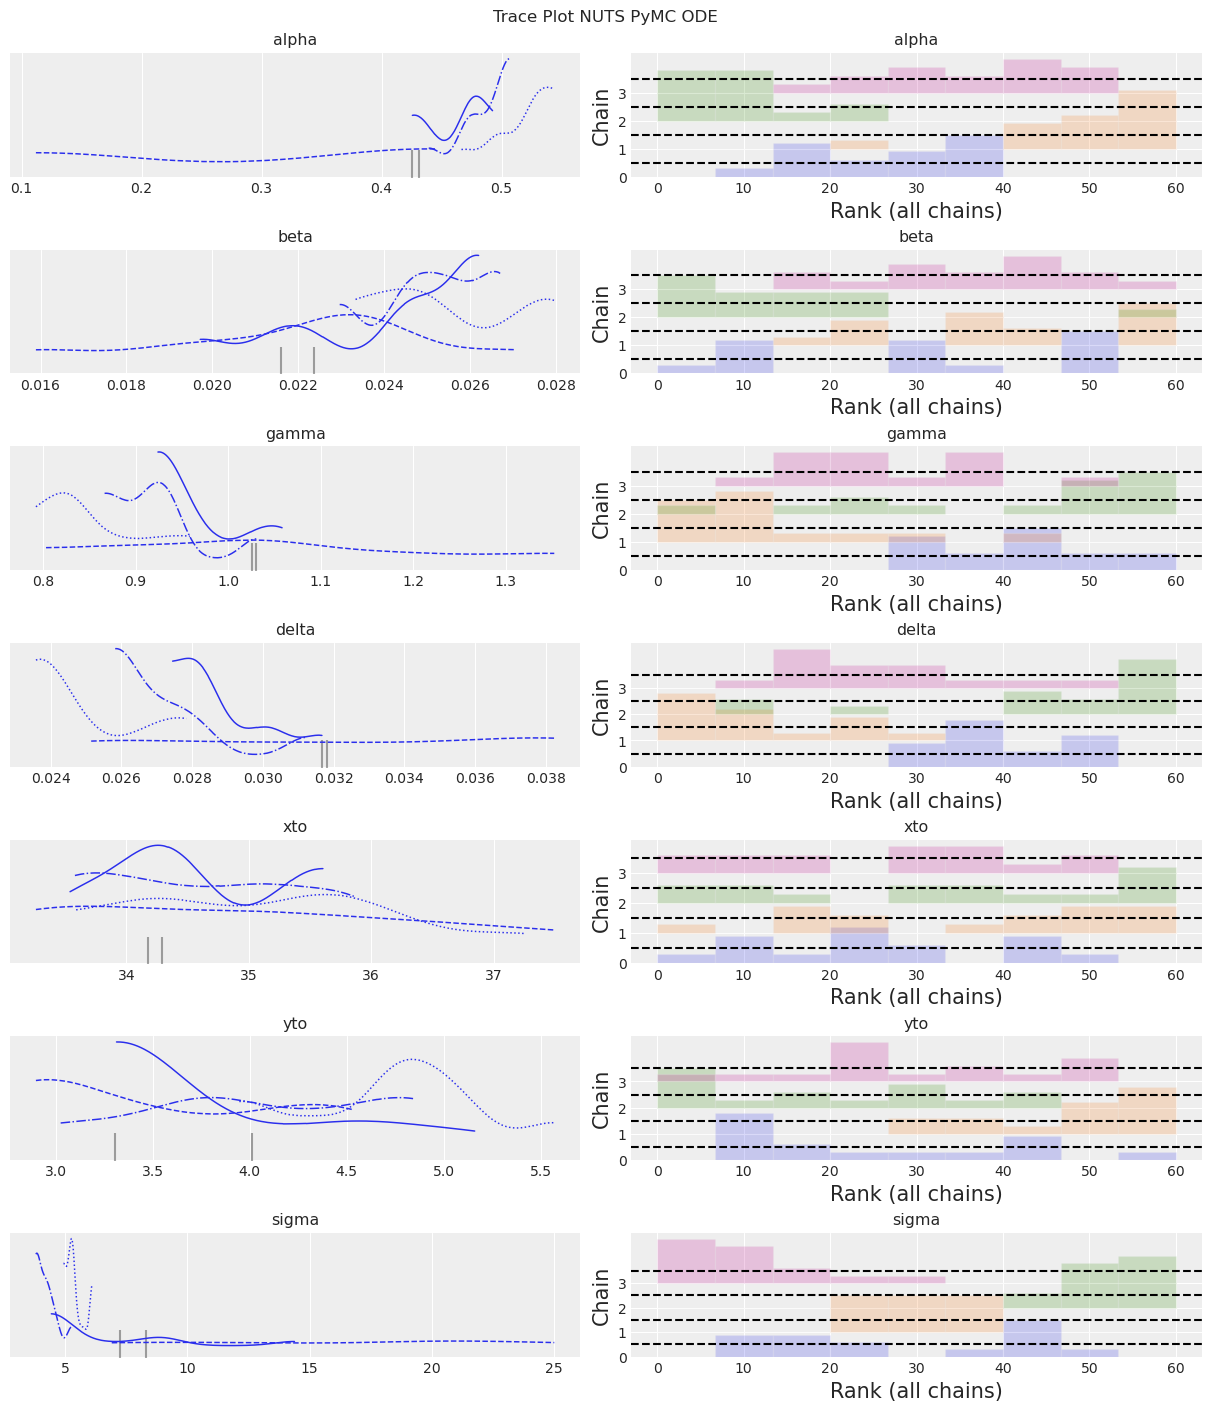

In [67]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

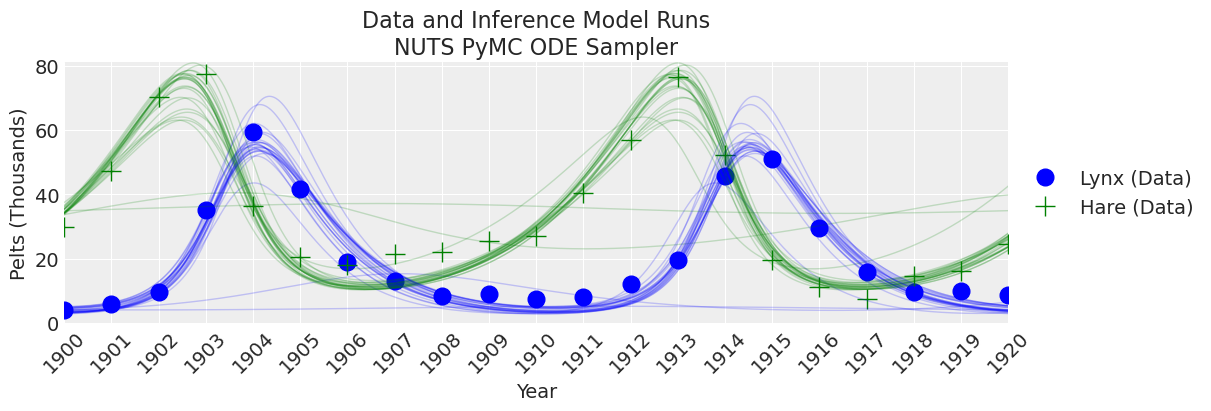

In [68]:
_, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

## Simulate with Pytensor Scan

In [69]:
# Lotka-Volterra forward simulation model using scan
def lv_scan_simulation_model(theta, steps_year=100, years=21):
    # variables to control time steps
    n_steps = years * steps_year
    dt = 1 / steps_year

    # PyMC model
    with pm.Model() as model:
        # Priors (these are static for testing)
        alpha = theta[0]
        beta = theta[1]
        gamma = theta[2]
        delta = theta[3]
        xt0 = theta[4]
        yt0 = theta[5]

        # Lotka-Volterra calculation function
        ## Similar to the right-hand-side functions used earlier
        ## but with dt applied to the equations
        def ode_update_function(x, y, alpha, beta, gamma, delta):
            x_new = x + (alpha * x - beta * x * y) * dt
            y_new = y + (-gamma * y + delta * x * y) * dt
            return x_new, y_new

        # Pytensor scan looping function
        ## The function argument names are not intuitive in this context!
        result, updates = pytensor.scan(
            fn=ode_update_function,  # function
            outputs_info=[xt0, yt0],  # initial conditions
            non_sequences=[alpha, beta, gamma, delta],  # parameters
            n_steps=n_steps,  # number of loops
        )

        # Put the results together and track the result
        pm.Deterministic("result", pm.math.stack([result[0], result[1]], axis=1))

    return model

Sampling: []
Sampling: []
Sampling: []
Sampling: []


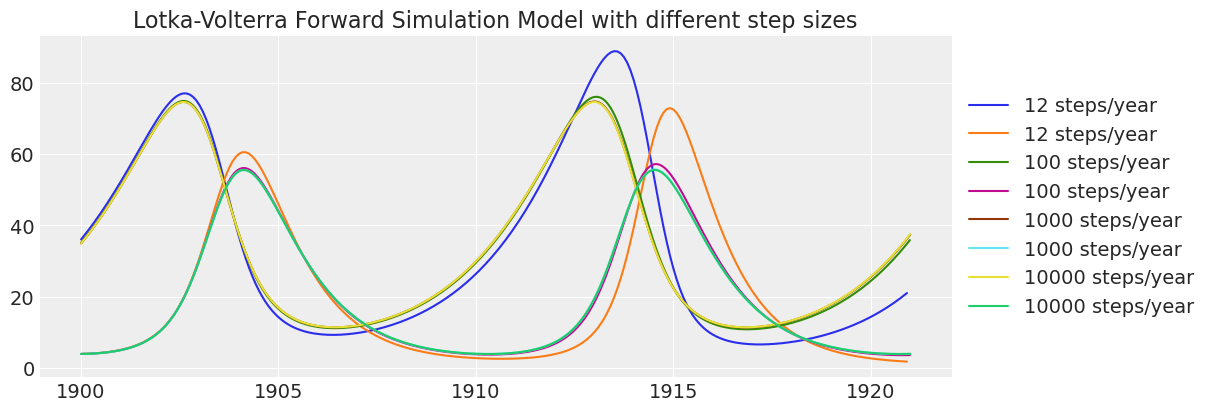

In [70]:
_, ax = plt.subplots(figsize=(12, 4))

steps_years = [12, 100, 1000, 10000]
for steps_year in steps_years:
    time = np.arange(1900, 1921, 1 / steps_year)
    model = lv_scan_simulation_model(theta, steps_year=steps_year)
    with model:
        prior = pm.sample_prior_predictive(1)
    ax.plot(time, prior.prior.result[0][0].values, label=str(steps_year) + " steps/year")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Lotka-Volterra Forward Simulation Model with different step sizes");

## Inference Using NUTs

In [71]:
def lv_scan_inference_model(theta, steps_year=100, years=21):
    # variables to control time steps
    n_steps = years * steps_year
    dt = 1 / steps_year

    # variables to control indexing to get annual values
    segment = [True] + [False] * (steps_year - 1)
    boolist_idxs = []
    for _ in range(years):
        boolist_idxs += segment

    # PyMC model
    with pm.Model() as model:
        # Priors
        alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
        beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
        gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
        delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
        xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
        yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
        sigma = pm.HalfNormal("sigma", 10)

        # Lotka-Volterra calculation function
        def ode_update_function(x, y, alpha, beta, gamma, delta):
            x_new = x + (alpha * x - beta * x * y) * dt
            y_new = y + (-gamma * y + delta * x * y) * dt
            return x_new, y_new

        # Pytensor scan is a looping function
        result, updates = pytensor.scan(
            fn=ode_update_function,  # function
            outputs_info=[xt0, yt0],  # initial conditions
            non_sequences=[alpha, beta, gamma, delta],  # parameters
            n_steps=n_steps,
        )  # number of loops

        # Put the results together
        final_result = pm.math.stack([result[0], result[1]], axis=1)
        # Filter the results down to annual values
        annual_value = final_result[np.array(boolist_idxs), :]

        # Likelihood function
        pm.Normal("Y_obs", mu=annual_value, sigma=sigma, observed=data[["hare", "lynx"]].values)
    return model

In [72]:
steps_year = 100
model = lv_scan_inference_model(theta, steps_year=steps_year)
sampler = "NUTS Pytensor Scan"
tune = draws = 50
with model:
    trace_scan = pm.sample(tune=tune, draws=draws)

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, xto, yto, sigma]


Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 256 seconds.
The number of samples is too small to check convergence reliably.


In [73]:
trace = trace_scan
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.478  0.023   0.438    0.519      0.003    0.002      74.0      96.0   
beta    0.025  0.001   0.022    0.027      0.000    0.000     118.0     157.0   
gamma   0.935  0.049   0.843    1.011      0.006    0.004      77.0      67.0   
delta   0.028  0.002   0.025    0.031      0.000    0.000      71.0      62.0   
xto    34.896  0.918  33.370   36.439      0.064    0.045     222.0     158.0   
yto     3.992  0.479   3.050    4.908      0.048    0.035     102.0      72.0   
sigma   4.234  0.506   3.358    5.179      0.066    0.048      64.0      31.0   

       r_hat  
alpha   1.03  
beta    1.02  
gamma   1.04  
delta   1.05  
xto     1.04  
yto     1.06  
sigma   1.07

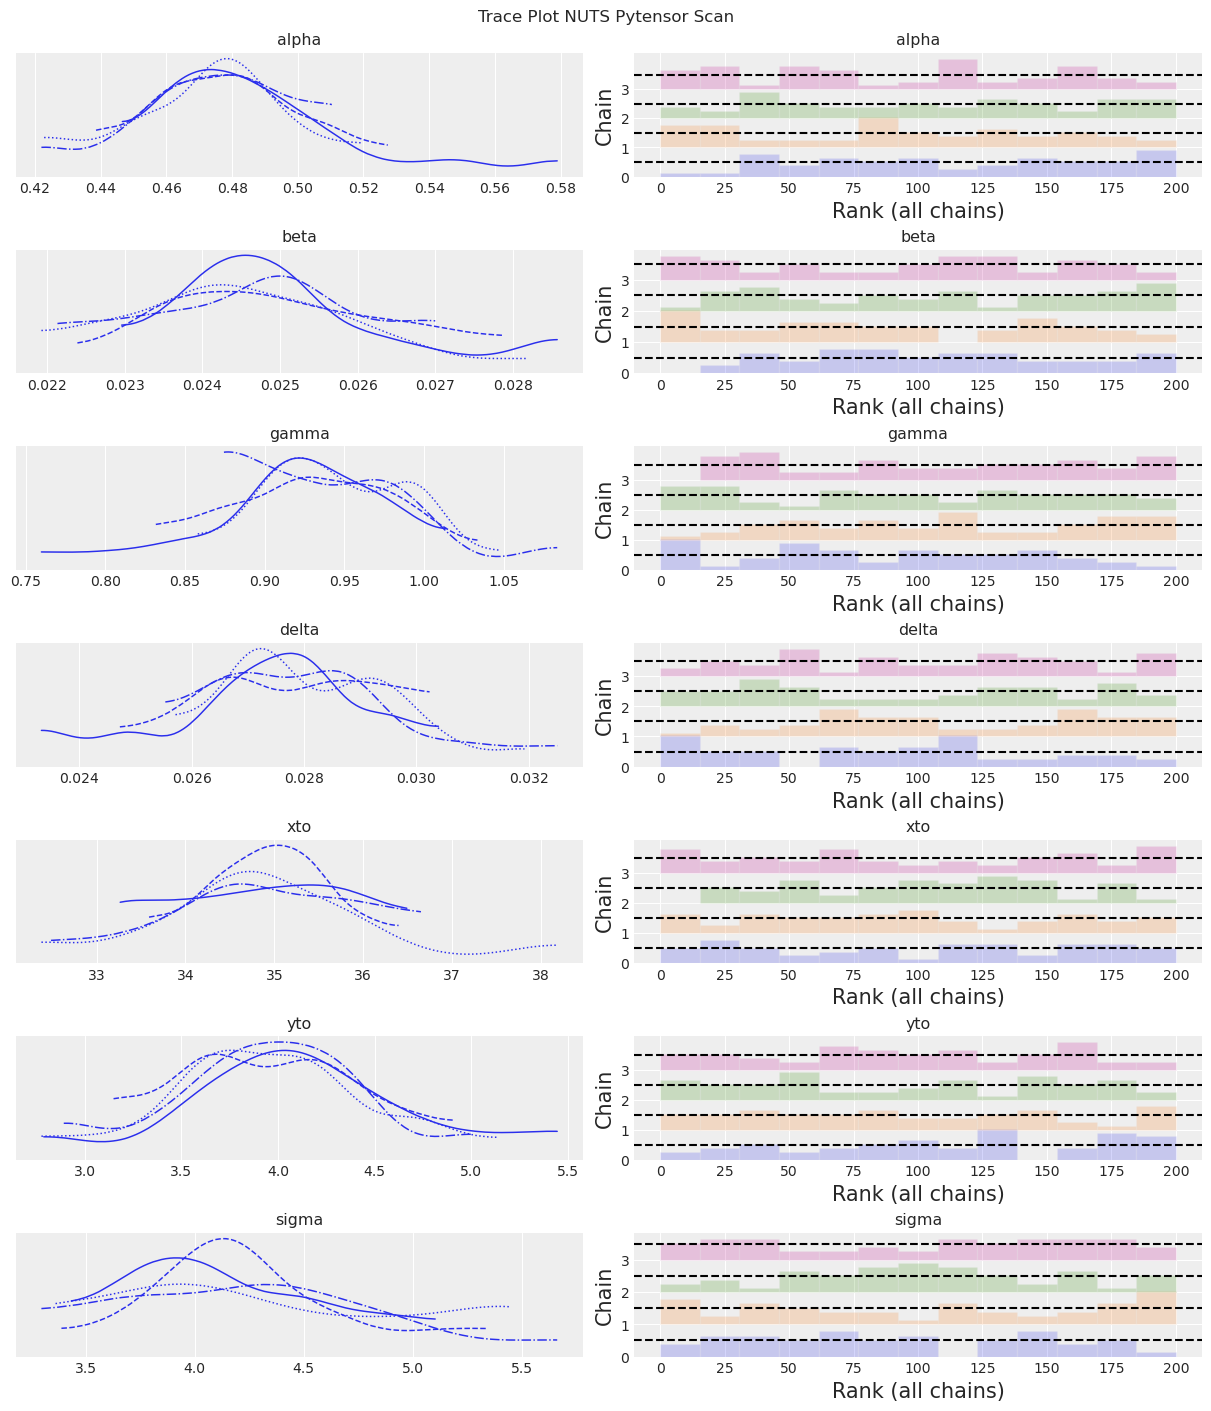

In [74]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

In [75]:
time = np.arange(1900, 1921, 0.01)
odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,)).shape

(2100, 2)

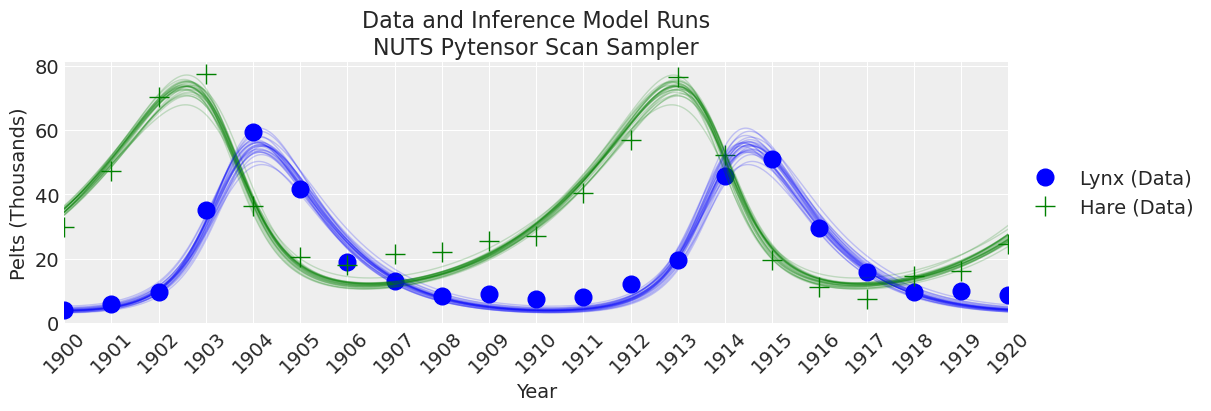

In [76]:
_, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");